In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import path
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

#Exploratory analysis

In [ ]:
nRowsRead = 1000
X_test = pd.read_csv('/content/drive/MyDrive/AI-ML-WF/data/Train/train.csv', delimiter=',', nrows = nRowsRead)
X_test.dataframeName = 'test.csv'
nRow, nCol = X_test.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 563 columns


In [ ]:
variances = X_test.var()
variances

<ipython-input-89-475e8231f4c8>:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variances = X_test.var()


tBodyAcc-mean()-X                       0.004921
tBodyAcc-mean()-Y                       0.001755
tBodyAcc-mean()-Z                       0.003136
tBodyAcc-std()-X                        0.183202
tBodyAcc-std()-Y                        0.251785
                                          ...   
angle(tBodyGyroJerkMean,gravityMean)    0.231379
angle(X,gravityMean)                    0.222444
angle(Y,gravityMean)                    0.122369
angle(Z,gravityMean)                    0.028291
subject                                 2.685085
Length: 562, dtype: float64

In [ ]:
min_variance_column = variances.idxmin()
min_variance_value = variances.min()
max_variance_column = variances.idxmax()
max_variance_value = variances.max()

In [ ]:
print("Highest variance column in the dataFrame",max_variance_value)
print("Lowest variance column in the dataFrame",min_variance_value)

Highest variance column in the dataFrame 2.6850850850850847
Lowest variance column in the dataFrame 0.001229486144733328


In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, i have picked columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    nGraphRow = int(nGraphRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

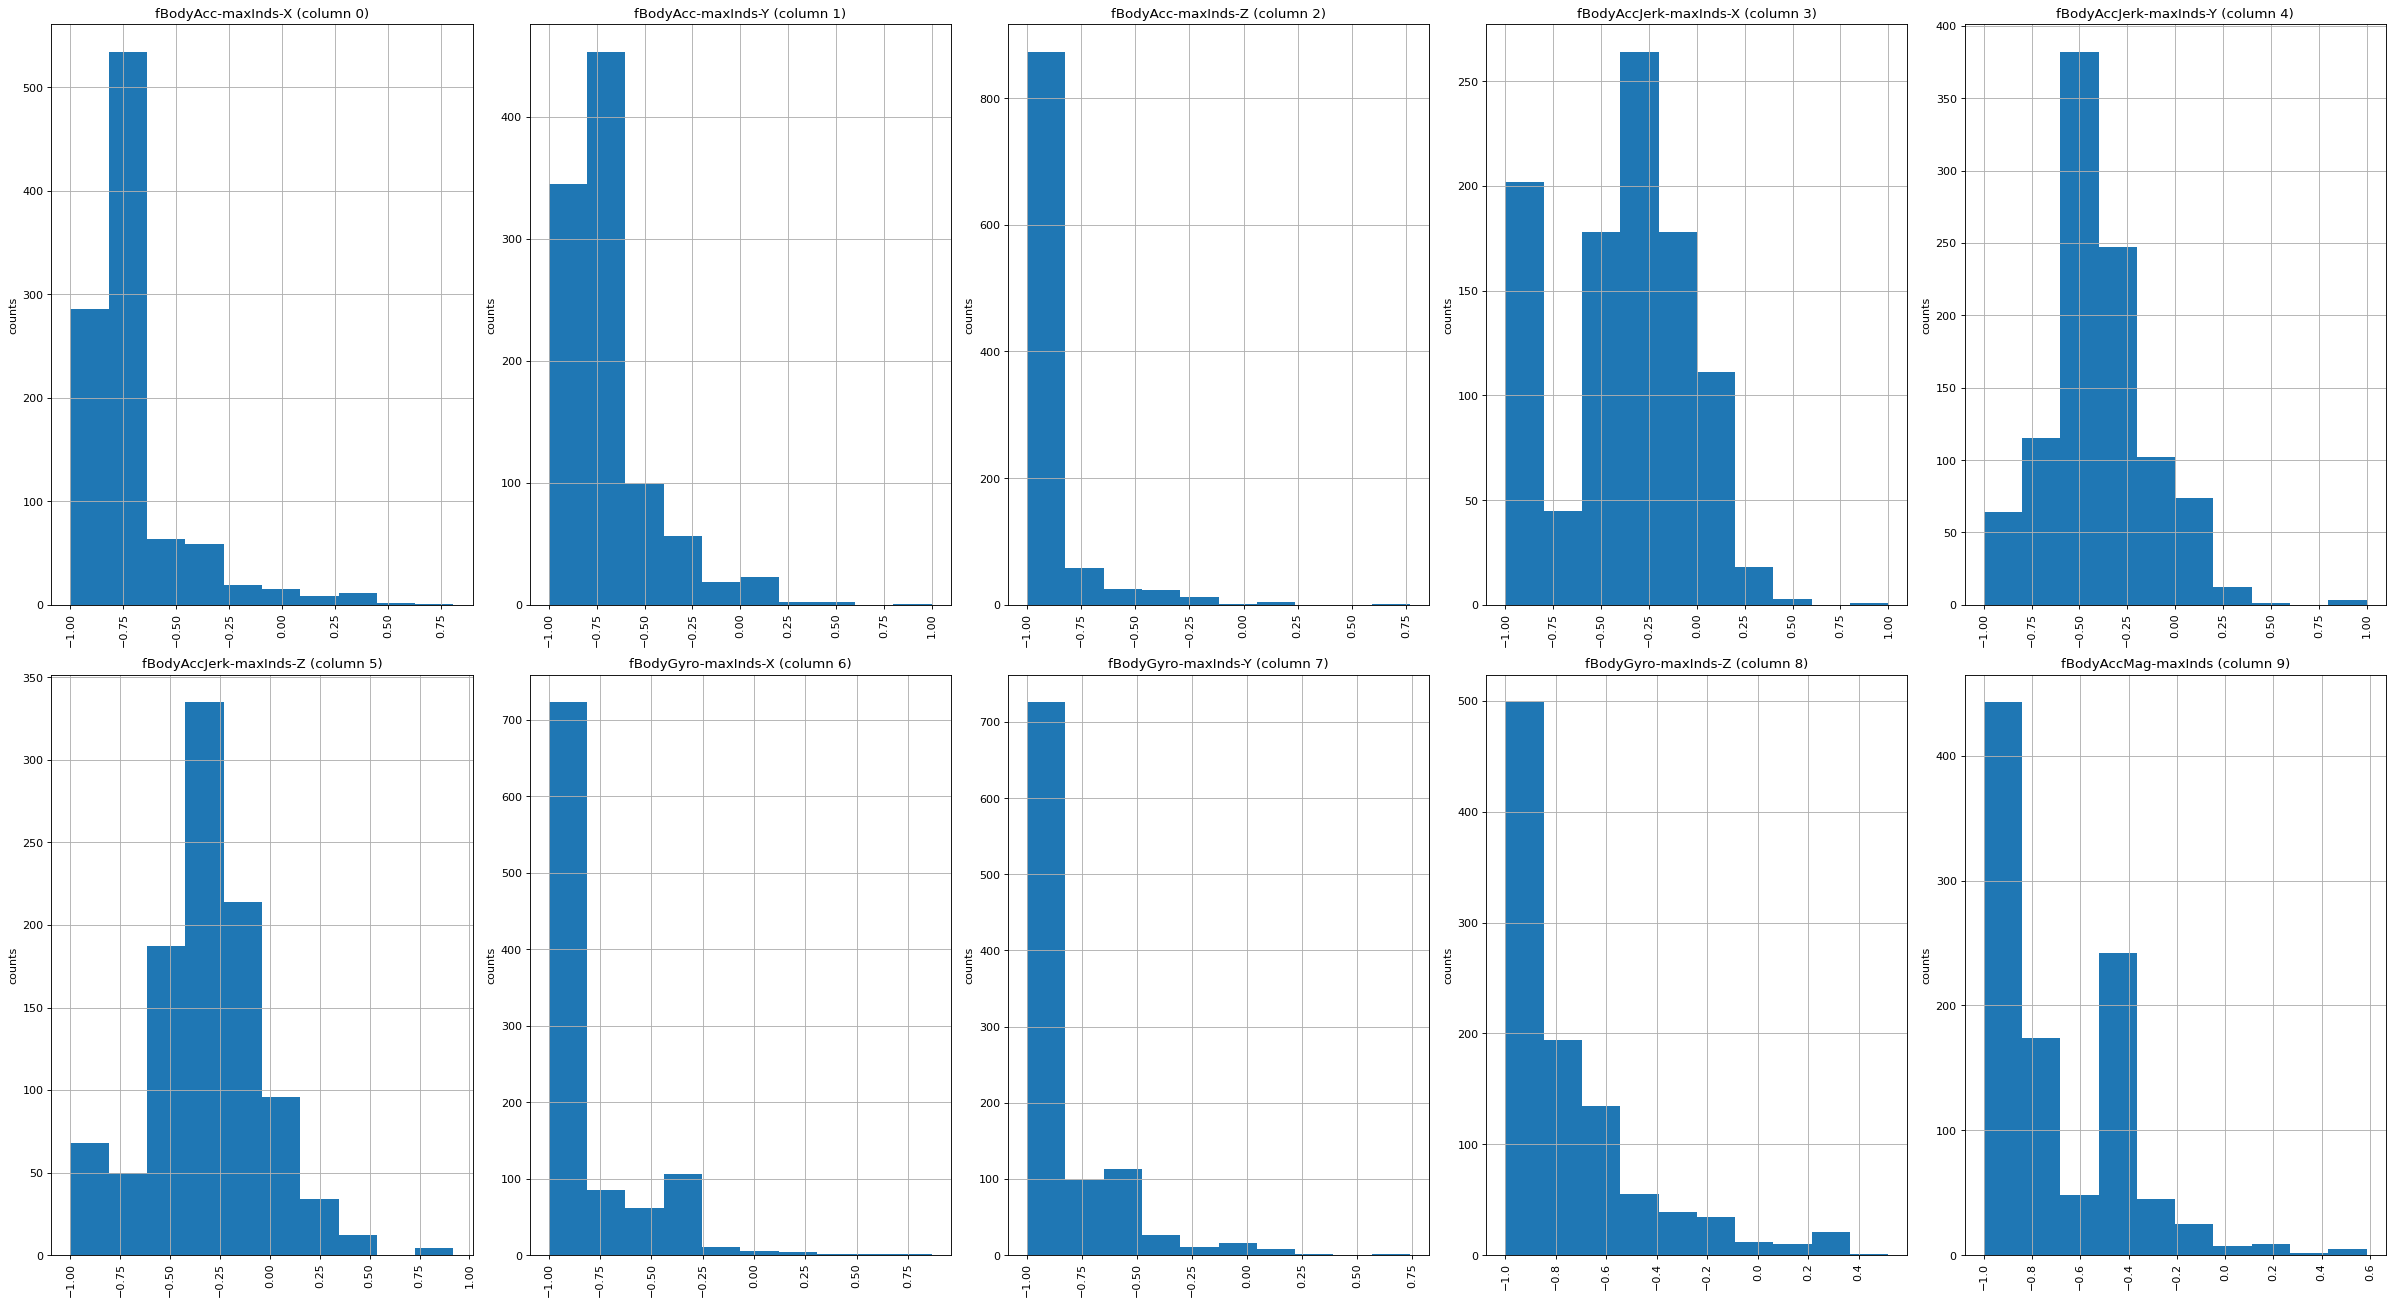

In [ ]:
plotPerColumnDistribution(X_test, 10, 5)

#Data Pre-processing

In [ ]:
path_Train = path.join('/content/drive/MyDrive/AI-ML-WF/data/Train')
path_Train_X = path.join(path_Train, 'train_x.csv')
path_Train_y = path.join(path_Train, 'train_y.csv')
X = pd.read_csv(path_Train_X, header=None, skiprows=[0])
y = pd.read_csv(path_Train_y, header=None, skiprows=[0])

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,561
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1


In [ ]:
y.head()

,0
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING


In [ ]:
X_temp = np.array(X)
#Here in this method i am mapping the categorical data to numerical data to perform prediction.
mapping = {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}
y1 = y[0].to_numpy()
y_temp = np.array([mapping[s] for s in y1])
print(X_temp.shape)
print(y_temp.shape)

(7352, 562)
(7352,)


In [ ]:
#Splitting the data into test and train companenets
train_X, test_X, train_y, test_y = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

#AdaBoostClassifier

##Hyper parameter tuning

In [ ]:
# random_state is set to 0 so that the results will be more comparable.
#Trying to tune the model by setting different parameters for the hyperparameters n_estimators
clf1 = AdaBoostClassifier(n_estimators=50, random_state=0)
clf2 = AdaBoostClassifier(n_estimators=100, random_state=0)

clf3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=50, random_state=0)
clf4 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=0)

clf5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=0)
clf6 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=0)

clfs = [clf1, clf2, clf3, clf4, clf5, clf6]
scores = []
for clf in clfs:
    clf.fit(train_X, train_y)
    scores.append([clf.score(train_X, train_y), clf.score(test_X, test_y)])

print('AdaBoost with 50 DTs of max_depth=1, train score:  %.4f' % scores[0][0])
print('AdaBoost with 50 DTs of max_depth=1, test score:  %.4f' % scores[0][1])
print('\r\n')
print('AdaBoost with 100 DTs of max_depth=1, train score:  %.4f' % scores[1][0])
print('AdaBoost with 100 DTs of max_depth=1, test score:  %.4f' % scores[1][1])
print('\r\n')
print('AdaBoost with 50 DTs of max_depth=2, train score:  %.4f' % scores[2][0])
print('AdaBoost with 50 DTs of max_depth=2, test score:  %.4f' % scores[2][1])
print('\r\n')
print('AdaBoost with 100 DTs of max_depth=2, train score:  %.4f' % scores[3][0])
print('AdaBoost with 100 DTs of max_depth=2, test score:  %.4f' % scores[3][1])
print('\r\n')
print('AdaBoost with 50 DTs of max_depth=3, train score:  %.4f' % scores[4][0])
print('AdaBoost with 50 DTs of max_depth=3, test score:  %.4f' % scores[4][1])
print('\r\n')
print('AdaBoost with 100 DTs of max_depth=3, train score:  %.4f' % scores[5][0])
print('AdaBoost with 100 DTs of max_depth=3, test score:  %.4f' % scores[5][1])
print('\r\n')

AdaBoost with 50 DTs of max_depth=1, train score:  0.5445
AdaBoost with 50 DTs of max_depth=1, test score:  0.5462


AdaBoost with 100 DTs of max_depth=1, train score:  0.5445
AdaBoost with 100 DTs of max_depth=1, test score:  0.5462


AdaBoost with 50 DTs of max_depth=2, train score:  0.8476
AdaBoost with 50 DTs of max_depth=2, test score:  0.8205


AdaBoost with 100 DTs of max_depth=2, train score:  0.9306
AdaBoost with 100 DTs of max_depth=2, test score:  0.9107


AdaBoost with 50 DTs of max_depth=3, train score:  0.9586
AdaBoost with 50 DTs of max_depth=3, test score:  0.9415


AdaBoost with 100 DTs of max_depth=3, train score:  0.9691
AdaBoost with 100 DTs of max_depth=3, test score:  0.9547




##Model Evaluation

In [ ]:
#Now that we have achieved 96% aacuarcy with this model. Here are few key preformance metrics.
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=0)
iter_list=[0.05, 0.1, 0.2, 0.5, 1]
for k in iter_list:
  train_X1, test_X1, train_y1, test_y1 = train_test_split(X_temp, y_temp, test_size=k, random_state=42)
  clf.fit(train_X1, train_y1)
  train_score = clf.score(train_X1, train_y1)
  print('For k = ', k, ', the training score is: ', train_score)

For k =  0.05 , the training score is:  0.9594788087056129
For k =  0.1 , the training score is:  0.964328899637243
For k =  0.2 , the training score is:  0.9642917871110356
For k =  0.5 , the training score is:  0.9676278563656148
For k =  1 , the training score is:  0.9627261597061624


In [ ]:
clf6.fit(train_X,train_y)

SVC(coef0=0, kernel='sigmoid', random_state=0)

In [ ]:
y_pred = clf6.predict(test_X)
print(metrics.classification_report(y_pred, test_y))

              precision    recall  f1-score   support

           0       0.71      0.37      0.48       820
           1       0.10      0.49      0.16        75
           2       0.25      0.55      0.35       189
           3       0.32      0.38      0.34       307
           4       0.55      0.27      0.36       633
           5       0.25      0.42      0.32       182

    accuracy                           0.37      2206
   macro avg       0.36      0.41      0.34      2206
weighted avg       0.51      0.37      0.39      2206



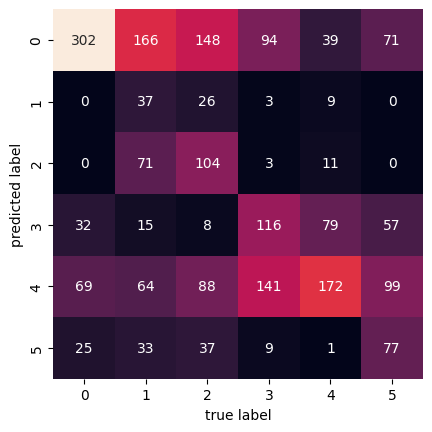

In [ ]:
mat = confusion_matrix(test_y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#Logistic Regression

In [ ]:
tolerance = 1e-4
lambda_ = 1e-200

clf_multinomial = LogisticRegression(C=1/lambda_, penalty='l2', tol=tolerance, solver='newton-cg', multi_class='multinomial')
clf_ovr = LogisticRegression(C=1/lambda_, penalty='l2', tol=tolerance, solver='newton-cg', multi_class='ovr')

clf_multinomial.fit(train_X, train_y)
clf_ovr.fit(train_X, train_y)

print('Logistic Regression without Regularization:')

print("multinomial LR, train score: %.4f" % clf_multinomial.score(train_X, train_y))
print("multinomial LR, test score: %.4f" % clf_multinomial.score(test_X, test_y))

print("ovr LR, train score: %.4f" % clf_ovr.score(train_X, train_y))
print("ovr LR, test score: %.4f" % clf_ovr.score(test_X, test_y))

Logistic Regression without Regularization:
multinomial LR, train score: 1.0000
multinomial LR, test score: 0.9755
ovr LR, train score: 1.0000
ovr LR, test score: 0.9778


##Hyper parameter tuning

In [ ]:
regularization_parameters = [1e2, 1e1, 1e0, 5e-3, 2e-3, 1e-4]
tolerance = 1e-2
limit_ = 1e-6
for i, lambda_ in enumerate(regularization_parameters):
    clf_l1_LR = LogisticRegression(C=1.0/lambda_, penalty='l1', tol=tolerance, solver='saga')
    clf_l2_LR = LogisticRegression(C=1.0/lambda_, penalty='l2', tol=tolerance, solver='saga')

    clf_l1_LR.fit(train_X, train_y)
    clf_l2_LR.fit(train_X, train_y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR < limit_) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR < limit_) * 100

    print("---------------------------")
    print("Regularization Parameter: ", lambda_)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("Train score with L1 penalty: %.4f" % clf_l1_LR.score(train_X, train_y))
    print("Test score with L1 penalty: %.4f" % clf_l1_LR.score(test_X, test_y))
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
    print("Train score with L2 penalty: %.4f" % clf_l2_LR.score(train_X, train_y))
    print("Test score with L2 penalty: %.4f" % clf_l2_LR.score(test_X, test_y))
    print("\r\n")

---------------------------
Regularization Parameter:  100.0
Sparsity with L1 penalty: 99.11%
Train score with L1 penalty: 0.8529
Test score with L1 penalty: 0.8654
Sparsity with L2 penalty: 53.14%
Train score with L2 penalty: 0.9518
Test score with L2 penalty: 0.9492


---------------------------
Regularization Parameter:  10.0
Sparsity with L1 penalty: 93.33%
Train score with L1 penalty: 0.9654
Test score with L1 penalty: 0.9583
Sparsity with L2 penalty: 51.93%
Train score with L2 penalty: 0.9786
Test score with L2 penalty: 0.9660


---------------------------
Regularization Parameter:  1.0
Sparsity with L1 penalty: 63.08%
Train score with L1 penalty: 0.9827
Test score with L1 penalty: 0.9705
Sparsity with L2 penalty: 52.22%
Train score with L2 penalty: 0.9833
Test score with L2 penalty: 0.9719


---------------------------
Regularization Parameter:  0.005
Sparsity with L1 penalty: 52.05%
Train score with L1 penalty: 0.9841
Test score with L1 penalty: 0.9728
Sparsity with L2 penalty:

##Model Evaluation

In [ ]:
tolerance = 1e-4
lambda_ = 1e-200
clf_multinomial = LogisticRegression(C=1/lambda_, penalty='l2', tol=tolerance, solver='newton-cg', multi_class='multinomial')
iter_list=[0.05, 0.1, 0.2, 0.5, 1]
for k in iter_list:
  train_X2, test_X2, train_y2, test_y2 = train_test_split(X_temp, y_temp, test_size=k, random_state=42)
  clf_multinomial.fit(train_X2, train_y2)
  train_score = clf_multinomial.score(train_X2, train_y2)
  print('For k = ', k, ', the training score is: ', train_score)

For k =  0.05 , the training score is:  1.0
For k =  0.1 , the training score is:  1.0
For k =  0.2 , the training score is:  1.0
For k =  0.5 , the training score is:  1.0
For k =  1 , the training score is:  1.0


In [ ]:
clf_multinomial.fit(train_X,train_y)

LogisticRegression(C=1e+200, multi_class='multinomial', solver='newton-cg')

In [ ]:
y2_pred = clf_multinomial.predict(test_X)
print(metrics.classification_report(y2_pred, test_y))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       425
           1       0.93      0.94      0.94       379
           2       0.96      0.93      0.94       422
           3       1.00      1.00      1.00       366
           4       0.99      0.99      0.99       311
           5       0.99      1.00      1.00       303

    accuracy                           0.98      2206
   macro avg       0.98      0.98      0.98      2206
weighted avg       0.98      0.98      0.98      2206



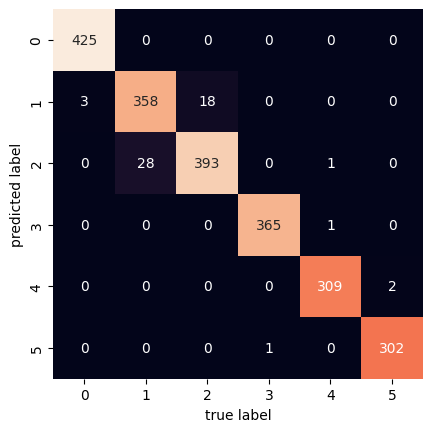

In [ ]:
mat = confusion_matrix(test_y, y2_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

##Using dimensionality reduction

In [ ]:
#Cutting down the columns which have variance more than 0.1
variance_threshhold_X = VarianceThreshold(threshold=0.1).fit_transform(train_X)
print(variance_threshhold_X.shape)

(5146, 189)


In [ ]:
tolerance = 1e-4
lambda_ = 1e-200
clf_multinomial = LogisticRegression(C=1/lambda_, penalty='l2', tol=tolerance, solver='newton-cg', multi_class='multinomial')
clf_multinomial.fit(variance_threshhold_X, train_y)
clf_multinomial.score(variance_threshhold_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


0.9976680917217257

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
kbest_MI_X = SelectKBest(mutual_info_classif, k=100).fit_transform(train_X, train_y)
print(kbest_MI_X.shape)

(5146, 100)


In [ ]:
clf_multinomial = LogisticRegression(C=1/lambda_, penalty='l2', tol=tolerance, solver='newton-cg', multi_class='multinomial')
clf_multinomial.fit(kbest_MI_X, train_y)
clf_multinomial.score(kbest_MI_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


0.9731830547998446

In [ ]:
from sklearn.feature_selection import RFE
clf_multinomial = LogisticRegression(C=1/lambda_, penalty='l2', tol=tolerance, solver='newton-cg', multi_class='multinomial')
rfe = RFE(estimator=clf_multinomial, n_features_to_select=100, step=20)
rfe.fit(train_X, train_y)

RFE(estimator=LogisticRegression(C=1e+200, multi_class='multinomial',
                                 solver='newton-cg'),
    n_features_to_select=100, step=20)

In [ ]:
print(sum(rfe.ranking_ == 1))
print(train_X[:, np.where(rfe.ranking_ == 1)[0].tolist()].shape)
rfe_X = train_X[:, np.where(rfe.ranking_ == 1)[0].tolist()]

100
(5146, 100)


In [ ]:
rfe.estimator_.score(rfe_X, train_y)

1.0

#Random Forest

##Hyper parameter tuning

In [ ]:
# random_state is set to 0 so that the results will be more comparable.
#Trying to tune the model by setting different parameters for the hyperparameters n_estimators
clf1 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

clf3 = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=0)
clf4 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

clf5 = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=0)
clf6 = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0)

clfs = [clf1, clf2, clf3, clf4, clf5, clf6]
rfscores = []
for clf in clfs:
    clf.fit(train_X, train_y)
    rfscores.append([clf.score(train_X, train_y), clf.score(test_X, test_y)])


print('RF with 50 DTs of max_depth=5, train score:  %.4f' % rfscores[0][0])
print('RF with 50 DTs of max_depth=5, test score:  %.4f' % rfscores[0][1])
print('\r\n')
print('RF with 100 DTs of max_depth=5, train score:  %.4f' % rfscores[1][0])
print('RF with 100 DTs of max_depth=5, test score:  %.4f' % rfscores[1][1])
print('\r\n')
print('RF with 50 DTs of max_depth=10, train score:  %.4f' % rfscores[2][0])
print('RF with 50 DTs of max_depth=10, test score:  %.4f' % rfscores[2][1])
print('\r\n')
print('RF with 100 DTs of max_depth=10, train score:  %.4f' % rfscores[3][0])
print('RF with 100 DTs of max_depth=10, test score:  %.4f' % rfscores[3][1])
print('\r\n')
print('RF with 50 DTs of max_depth=15, train score:  %.4f' % rfscores[4][0])
print('RF with 50 DTs of max_depth=15, test score:  %.4f' % rfscores[4][1])
print('\r\n')
print('RF with 100 DTs of max_depth=15, train score:  %.4f' % rfscores[5][0])
print('RF with 100 DTs of max_depth=15, test score:  %.4f' % rfscores[5][1])
print('\r\n')

RF with 50 DTs of max_depth=5, train score:  0.9460
RF with 50 DTs of max_depth=5, test score:  0.9365


RF with 100 DTs of max_depth=5, train score:  0.9446
RF with 100 DTs of max_depth=5, test score:  0.9356


RF with 50 DTs of max_depth=10, train score:  0.9977
RF with 50 DTs of max_depth=10, test score:  0.9773


RF with 100 DTs of max_depth=10, train score:  0.9975
RF with 100 DTs of max_depth=10, test score:  0.9773


RF with 50 DTs of max_depth=15, train score:  1.0000
RF with 50 DTs of max_depth=15, test score:  0.9769


RF with 100 DTs of max_depth=15, train score:  1.0000
RF with 100 DTs of max_depth=15, test score:  0.9791




##Model evaluation

In [ ]:
#Now that we have achieved 100% aacuarcy for this random forest model. Here are few key preformance metrics.
rfclf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0)
iter_list=[0.05, 0.1, 0.2, 0.5, 1]
for k in iter_list:
  train_X3, test_X3, train_y3, test_y3 = train_test_split(X_temp, y_temp, test_size=k, random_state=42)
  rfclf.fit(train_X3, train_y3)
  train_score = rfclf.score(train_X3, train_y3)
  print('For k = ', k, ', the training score is: ', train_score)

For k =  0.05 , the training score is:  1.0
For k =  0.1 , the training score is:  1.0
For k =  0.2 , the training score is:  1.0
For k =  0.5 , the training score is:  1.0
For k =  1 , the training score is:  1.0


In [ ]:
rfclf.fit(train_X,train_y)

RandomForestClassifier(max_depth=15, random_state=0)

In [ ]:
y3_pred = rfclf.predict(test_X)
print(metrics.classification_report(y3_pred, test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       428
           1       0.96      0.96      0.96       385
           2       0.97      0.96      0.96       412
           3       0.98      0.99      0.99       363
           4       0.97      0.99      0.98       306
           5       0.99      0.96      0.98       312

    accuracy                           0.98      2206
   macro avg       0.98      0.98      0.98      2206
weighted avg       0.98      0.98      0.98      2206



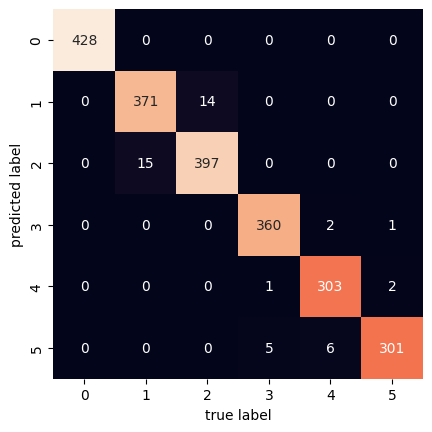

In [ ]:
mat = confusion_matrix(test_y, y3_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#SVM model

##Hyper parameter tuning

In [ ]:
# random_state is set to 0 so that the results will be more comparable.
#Trying to tune the model by setting different parameters for the hyperparameters n_estimators
clf1 = svm.SVC(kernel="linear", random_state=0)

clf2 = svm.SVC(kernel="rbf", gamma='scale', random_state=0)

clf3 = svm.SVC(kernel="poly", gamma='scale', degree=2, coef0=1, random_state=0)
clf4 = svm.SVC(kernel="poly", gamma='scale', degree=5, coef0=1, random_state=0)
clf5 = svm.SVC(kernel="poly", gamma='scale', degree=10, coef0=1, random_state=0)

clf6 = svm.SVC(kernel="sigmoid", gamma='scale', coef0=0, random_state=0)
clf7 = svm.SVC(kernel="sigmoid", gamma='scale', coef0=1, random_state=0)

clfs = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]
svmscores = []
for clf in clfs:
    clf.fit(train_X, train_y)
    svmscores.append([clf.score(train_X, train_y), clf.score(test_X, test_y)])


print('SVM with linear kernel, train score:  %.4f' % svmscores[0][0])
print('SVM with linear kernel, test score:  %.4f' % svmscores[0][1])
print('\r\n')
print('SVM with rbf kernel, train score:  %.4f' % svmscores[1][0])
print('SVM with rbf kernel, test score:  %.4f' % svmscores[1][1])
print('\r\n')
print('SVM with polynomial kernel degree=2, train score:  %.4f' % svmscores[2][0])
print('SVM with polynomial kernel degree=2, test score:  %.4f' % svmscores[2][1])
print('\r\n')
print('SVM with polynomial kernel degree=5, train score:  %.4f' % svmscores[3][0])
print('SVM with polynomial kernel degree=5, test score:  %.4f' % svmscores[3][1])
print('\r\n')
print('SVM with polynomial kernel degree=10, train score:  %.4f' % svmscores[4][0])
print('SVM with polynomial kernel degree=10, test score:  %.4f' % svmscores[4][1])
print('\r\n')
print('SVM with sigmoid kernel coef0=0, train score:  %.4f' % svmscores[5][0])
print('SVM with sigmoid kernel coef0=0, test score:  %.4f' % svmscores[5][1])
print('\r\n')
print('SVM with sigmoid kernel coef0=1, train score:  %.4f' % svmscores[6][0])
print('SVM with sigmoid kernel coef0=1, test score:  %.4f' % svmscores[6][1])
print('\r\n')

SVM with linear kernel, train score:  0.9944
SVM with linear kernel, test score:  0.9846


SVM with rbf kernel, train score:  0.9479
SVM with rbf kernel, test score:  0.9492


SVM with polynomial kernel degree=2, train score:  0.9709
SVM with polynomial kernel degree=2, test score:  0.9642


SVM with polynomial kernel degree=5, train score:  0.9957
SVM with polynomial kernel degree=5, test score:  0.9887


SVM with polynomial kernel degree=10, train score:  1.0000
SVM with polynomial kernel degree=10, test score:  0.9832


SVM with sigmoid kernel coef0=0, train score:  0.3649
SVM with sigmoid kernel coef0=0, test score:  0.3663


SVM with sigmoid kernel coef0=1, train score:  0.4036
SVM with sigmoid kernel coef0=1, test score:  0.3953




##Using Lasso regrssion

In [ ]:
#Lasso regression.
tolerance = 1e-2
limit_ = 1e-6
regularization_parameters = [1e2, 1e1, 1e0, 1e-1, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 1e-4]
for i, lambda_ in enumerate(regularization_parameters):
    clf_l1 = LinearSVC(C=1.0/lambda_, penalty='l1', loss='squared_hinge', dual=False, tol=tolerance)
    clf_l2 = LinearSVC(C=1.0/lambda_, penalty='l2', loss='squared_hinge', dual=False, tol=tolerance)

    clf_l1.fit(train_X, train_y)
    clf_l2.fit(train_X, train_y)

    sparsity_l1 = np.mean(clf_l1.coef_ < limit_) * 100
    sparsity_l2 = np.mean(clf_l2.coef_ < limit_) * 100
    print("---------------------------")
    print("Regularization Parameter: ", lambda_)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1)
    print("Train score with L1 penalty: %.4f" % clf_l1.score(train_X, train_y))
    print("Test score with L1 penalty: %.4f" % clf_l1.score(test_X, test_y))
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2)
    print("Train score with L2 penalty: %.4f" % clf_l2.score(train_X, train_y))
    print("Test score with L2 penalty: %.4f" % clf_l2.score(test_X, test_y))
    print("\r\n")

---------------------------
Regularization Parameter:  100.0
Sparsity with L1 penalty: 97.36%
Train score with L1 penalty: 0.9320
Test score with L1 penalty: 0.9352
Sparsity with L2 penalty: 47.60%
Train score with L2 penalty: 0.9821
Test score with L2 penalty: 0.9737


---------------------------
Regularization Parameter:  10.0
Sparsity with L1 penalty: 89.89%
Train score with L1 penalty: 0.9887
Test score with L1 penalty: 0.9801
Sparsity with L2 penalty: 47.78%
Train score with L2 penalty: 0.9905
Test score with L2 penalty: 0.9814


---------------------------
Regularization Parameter:  1.0
Sparsity with L1 penalty: 76.99%
Train score with L1 penalty: 0.9953
Test score with L1 penalty: 0.9864
Sparsity with L2 penalty: 47.84%
Train score with L2 penalty: 0.9907
Test score with L2 penalty: 0.9828


---------------------------
Regularization Parameter:  0.1
Sparsity with L1 penalty: 52.37%
Train score with L1 penalty: 0.9977
Test score with L1 penalty: 0.9832
Sparsity with L2 penalty: 4

##Model Evaluation

In [ ]:
clfsvm = svm.SVC(kernel="linear", random_state=0)
iter_list=[0.05, 0.1, 0.2, 0.5, 1]
for k in iter_list:
  train_X4, test_X4, train_y4, test_y4 = train_test_split(X_temp, y_temp, test_size=k, random_state=42)
  clfsvm.fit(train_X4, train_y4)
  train_score = clfsvm.score(train_X4, train_y4)
  print('For k = ', k, ', the training score is: ', train_score)

For k =  0.05 , the training score is:  0.9939862542955327
For k =  0.1 , the training score is:  0.9935006045949214
For k =  0.2 , the training score is:  0.9937085529671824
For k =  0.5 , the training score is:  0.9964635473340587
For k =  1 , the training score is:  0.994014419806829


In [ ]:
clfsvm.fit(train_X,train_y)

SVC(kernel='linear', random_state=0)

In [ ]:
y4_pred = clfsvm.predict(test_X)
print(metrics.classification_report(y4_pred, test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       428
           1       0.96      0.97      0.96       382
           2       0.97      0.96      0.96       415
           3       1.00      1.00      1.00       366
           4       1.00      0.99      1.00       312
           5       0.99      1.00      1.00       303

    accuracy                           0.98      2206
   macro avg       0.99      0.99      0.99      2206
weighted avg       0.98      0.98      0.98      2206



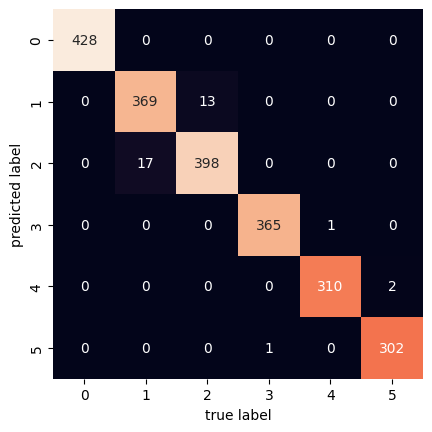

In [ ]:
mat = confusion_matrix(test_y, y4_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#Gaussian Mixture & K-Means

In [ ]:
kmeans = KMeans(n_clusters=12, n_init=50, max_iter=500).fit(train_X)

In [ ]:
kmeans.inertia_

121839.4592143551

In [ ]:
gmm = GaussianMixture(n_components=12, covariance_type='full', n_init=1, max_iter=500, verbose=1).fit(train_X)

Initialization 0
  Iteration 10
Initialization converged: True


In [ ]:
gmm.aic(train_X)

-16845276.919248316

In [ ]:
gmm.bic(train_X)

-4373944.276661266

In [ ]:
# rand index for kmeans:
kmeans_y = kmeans.predict(train_X)
print('rand index for kmeans: ', metrics.adjusted_rand_score(kmeans_y, train_y))
# rand index for gmm:
gmm_y = gmm.predict(train_X)
print('rand index for gmm: ', metrics.adjusted_rand_score(gmm_y, train_y))

rand index for kmeans:  0.172794039781128
rand index for gmm:  0.1811761121237658


##Model Evaluation

In [ ]:
pca = PCA(n_components=50)
pca_X = pca.fit_transform(train_X)
print(sum(pca.explained_variance_ratio_)*100)

97.11883387434771


In [ ]:
kmeans = KMeans(n_clusters=12, n_init=50, max_iter=500).fit(pca_X)

In [ ]:
kmeans.inertia_

136221.91744709

In [ ]:
gmm = GaussianMixture(n_components=12, covariance_type='full', n_init=1, max_iter=500, verbose=1).fit(pca_X)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


In [ ]:
# rand index for kmeans:
kmeans_y = kmeans.predict(pca_X)
print('rand index for kmeans: ', metrics.adjusted_rand_score(kmeans_y, train_y))
# rand index for gmm:
gmm_y = gmm.predict(pca_X)
print('rand index for gmm: ', metrics.adjusted_rand_score(gmm_y, train_y))

rand index for kmeans:  0.17242131848157205
rand index for gmm:  0.2774053652939074


#Data Visualization

In [ ]:
plt_data=[]
for i in range(100):
    pca = PCA(n_components=i+1)
    pca.fit_transform(train_X)
    #pca.explained_variance_
    plt_data.append(sum(pca.explained_variance_ratio_)*100)

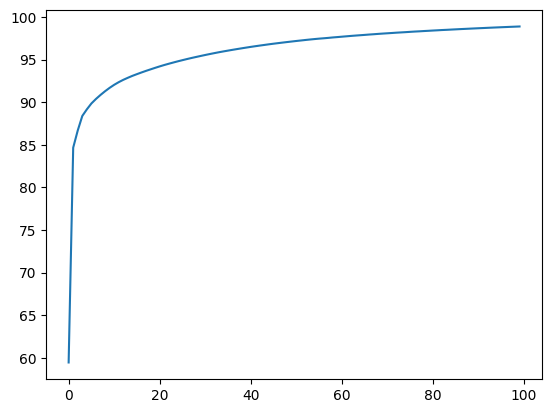

In [ ]:
plt.plot(plt_data)
plt.show()

In [ ]:
plt_data[50]

97.17999147161106

In [ ]:
pca_50 = PCA(n_components=50)
pca_50_X = pca_50.fit_transform(train_X)

In [ ]:
from sklearn.manifold import TSNE
tsne_50 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_50_X = tsne_50.fit_transform(pca_50_X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5146 samples in 0.001s...
[t-SNE] Computed neighbors for 5146 samples in 0.608s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5146
[t-SNE] Computed conditional probabilities for sample 2000 / 5146
[t-SNE] Computed conditional probabilities for sample 3000 / 5146
[t-SNE] Computed conditional probabilities for sample 4000 / 5146
[t-SNE] Computed conditional probabilities for sample 5000 / 5146
[t-SNE] Computed conditional probabilities for sample 5146 / 5146
[t-SNE] Mean sigma: 1.837393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.968147
[t-SNE] KL divergence after 500 iterations: 0.737669


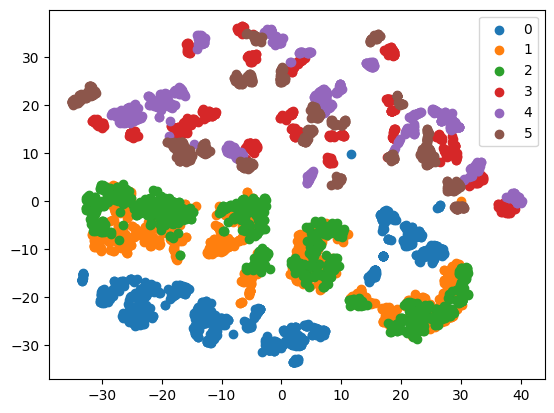

In [ ]:
X1 = tsne_50_X[:, 0]
X2 = tsne_50_X[:, 1]
y = train_y
fig, ax = plt.subplots()
for label in np.unique(y):
    indices = np.where(y == label)[0].tolist()
    ax.scatter(X1[indices], X2[indices], label=label)
ax.legend()
plt.show()

In [ ]:
def plot_2d(X, y):
    X1 = X[:, 0]
    X2 = X[:, 1]
    fig, ax = plt.subplots()
    for label in np.unique(y):
        indices = np.where(y == label)[0].tolist()
        ax.scatter(X1[indices], X2[indices], label=label)
    ax.legend()
    plt.show()
    plt.close('all')

In [ ]:
kmeans = KMeans(n_clusters=12, n_init=50, max_iter=500).fit(train_X)
gmm = GaussianMixture(n_components=12, covariance_type='full', n_init=1, max_iter=500, verbose=1).fit(train_X)

Initialization 0
Initialization converged: True


In [ ]:
kmeans_y = kmeans.predict(train_X)
gmm_y = gmm.predict(train_X)

In [ ]:
pca = PCA(n_components=50)
pca_X = pca.fit_transform(train_X)
kmeans_pca = KMeans(n_clusters=12, n_init=50, max_iter=500).fit(pca_X)
gmm_pca = GaussianMixture(n_components=12, covariance_type='full', n_init=1, max_iter=500, verbose=1).fit(pca_X)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


In [ ]:
kmeans_pca_y = kmeans_pca.predict(pca_X)
gmm_pca_y = gmm_pca.predict(pca_X)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_X = tsne.fit_transform(train_X)
tsne_pca = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_X = tsne.fit_transform(pca_X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5146 samples in 0.002s...
[t-SNE] Computed neighbors for 5146 samples in 1.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5146
[t-SNE] Computed conditional probabilities for sample 2000 / 5146
[t-SNE] Computed conditional probabilities for sample 3000 / 5146
[t-SNE] Computed conditional probabilities for sample 4000 / 5146
[t-SNE] Computed conditional probabilities for sample 5000 / 5146
[t-SNE] Computed conditional probabilities for sample 5146 / 5146
[t-SNE] Mean sigma: 1.893595
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.549538
[t-SNE] KL divergence after 300 iterations: 1.672197
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5146 samples in 0.001s...
[t-SNE] Computed neighbors for 5146 samples in 0.297s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5146
[t-SNE] Computed conditional probabilities for sample 2000 / 5146
[t-SNE] Computed conditional

2d plot of original train_X vs real labels train_y


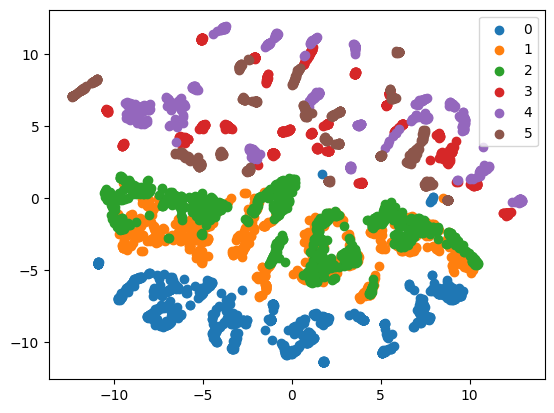



2d plot of original train_X vs predicted labels using kmeans kmeans_y


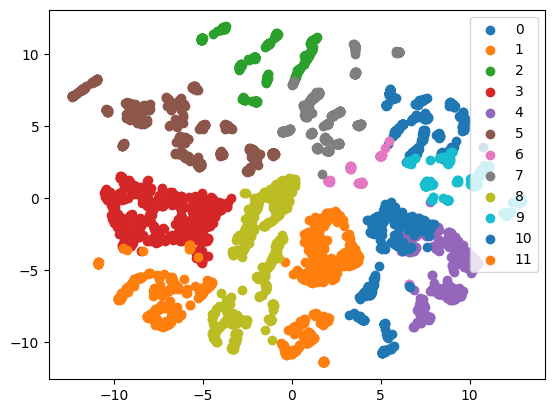



2d plot of original train_X vs predicted labels using gmm gmm_y


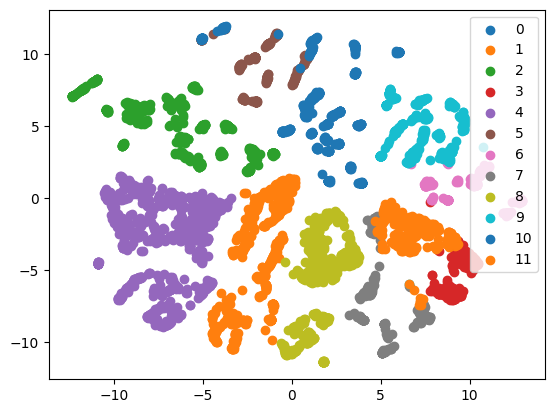



2d plot of pca transformed train_X vs real labels train_y


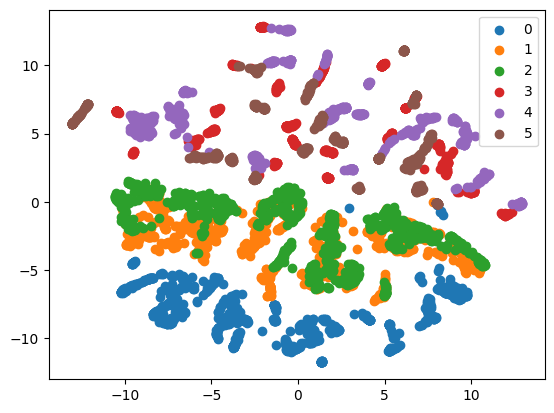



2d plot of pca transformed train_X vs predicted labels using kmeans kmeans_pca_y


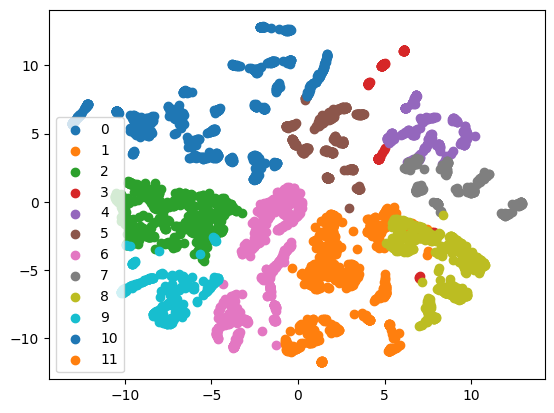



2d plot of pca transformed train_X vs predicted labels using gmm gmm_pca_y


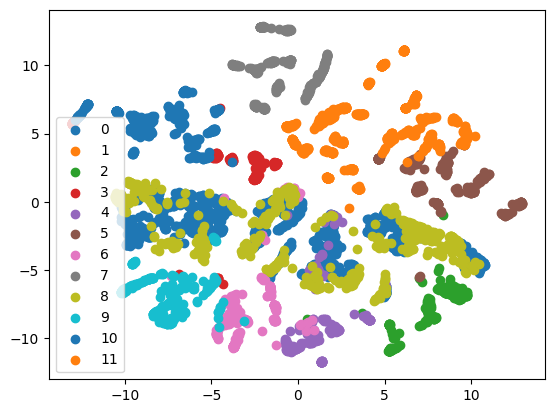

In [ ]:
print('2d plot of original train_X vs real labels train_y')
plot_2d(tsne_X, train_y)
print('\r\n')

print('2d plot of original train_X vs predicted labels using kmeans kmeans_y')
plot_2d(tsne_X, kmeans_y)
print('\r\n')

print('2d plot of original train_X vs predicted labels using gmm gmm_y')
plot_2d(tsne_X, gmm_y)
print('\r\n')

print('2d plot of pca transformed train_X vs real labels train_y')
plot_2d(tsne_pca_X, train_y)
print('\r\n')

print('2d plot of pca transformed train_X vs predicted labels using kmeans kmeans_pca_y')
plot_2d(tsne_pca_X, kmeans_pca_y)
print('\r\n')

print('2d plot of pca transformed train_X vs predicted labels using gmm gmm_pca_y')
plot_2d(tsne_pca_X, gmm_pca_y)
print('\r\n')